In [ ]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 16
sc.set_figure_params(dpi=100,dpi_save=800, figsize=(5,5), frameon=False)
%config InlineBackend.figure_format='retina'

In [2]:
noci_mdata = mu.read('./Results_h5ad/05_noci_mdata_subcluster_CCAT.h5mu')

/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


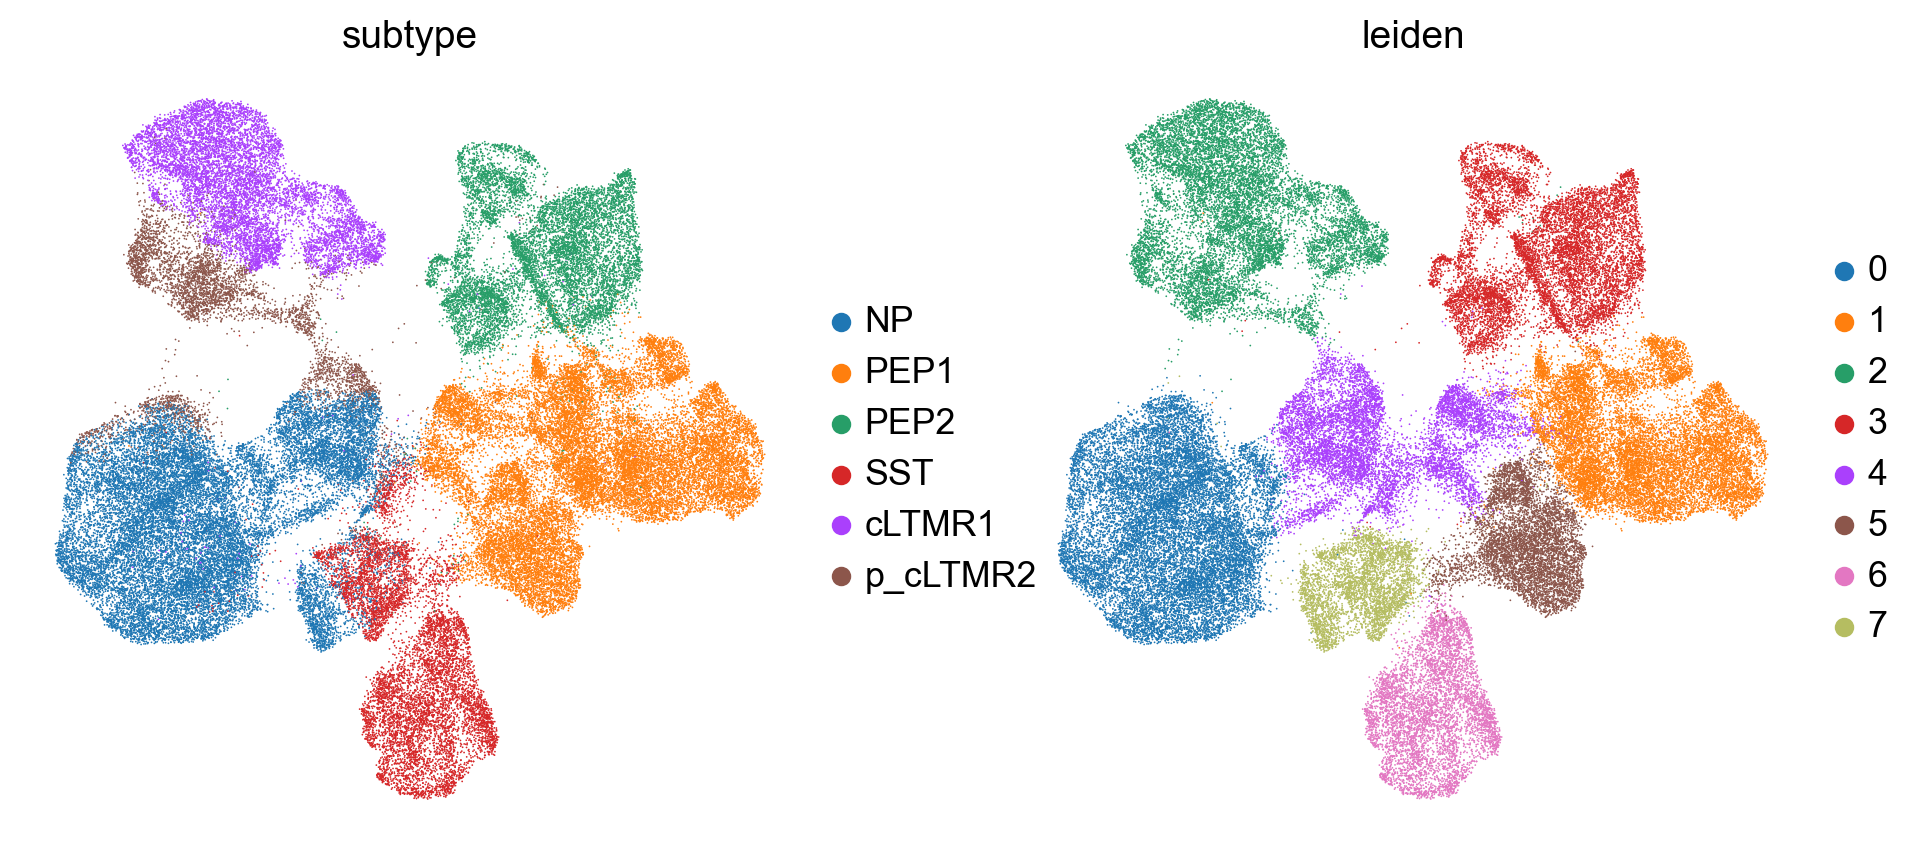

In [3]:
mu.pl.umap(noci_mdata, color=['subtype','leiden'])

In [4]:
# reconstruct the raw counts from the MULTIVI model
import torch
torch.device('mps')
count = torch.distributions.negative_binomial.NegativeBinomial(torch.Tensor(noci_mdata['rna'].layers['scVI_gene']), logits=True).sample()

from scipy.sparse import csr_matrix
noci_mdata['rna'].layers['NB_counts'] = csr_matrix(np.array(count))

In [ ]:
adata = noci_mdata['rna'].copy()
adata.X = adata.layers["NB_counts"].toarray()
del adata.obsm
del adata.layers
del adata.obs
del adata.var
del adata.uns

In [ ]:
batches = noci_mdata.obs.Source.to_list()

In [2]:
import rpy2
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_7837/2909349582.py:3: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [ ]:
%%R -i adata -i batches -o ct
rownames(adata@assays@data$X)=rownames(adata)
colnames(adata@assays@data$X)=colnames(adata)
results=CytoTRACE::CytoTRACE(adata@assays@data$X,batch=batches,ncores=4)
saveRDS(results, './cyto_results.rds')
ct=results$CytoTRACE

In [19]:
noci_mdata.obs['CytoTRACE'] = ct

In [138]:
noci_mdata['rna'].obs['CytoTRACE'] = ct

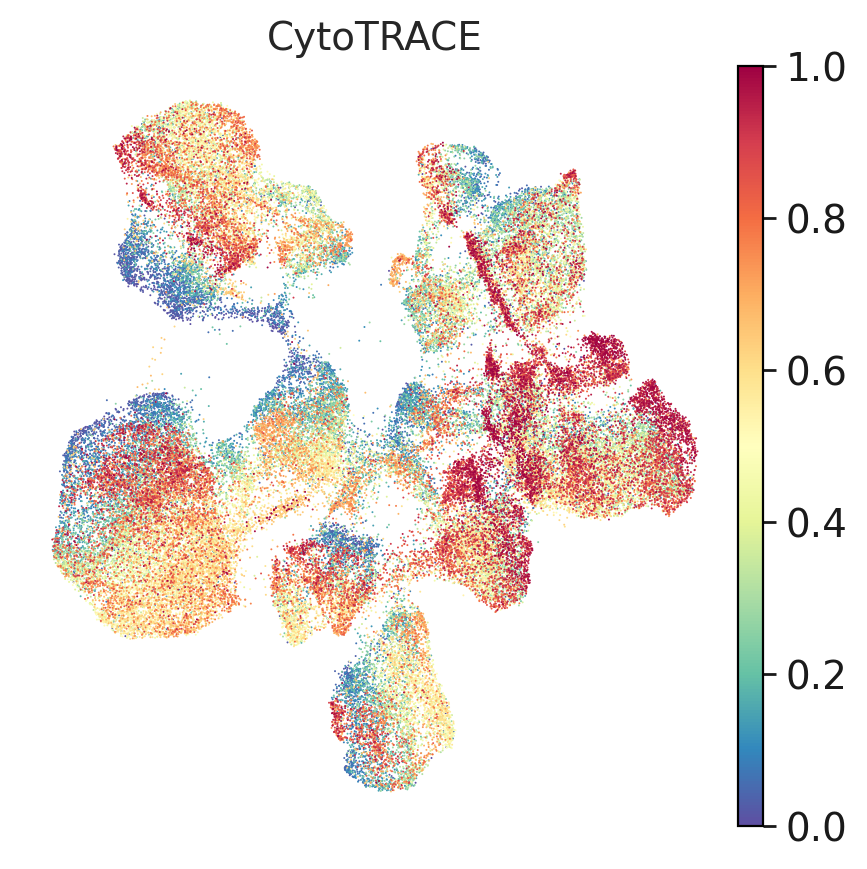

In [37]:
mu.pl.umap(noci_mdata,color="CytoTRACE",cmap="Spectral_r", size=2)

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

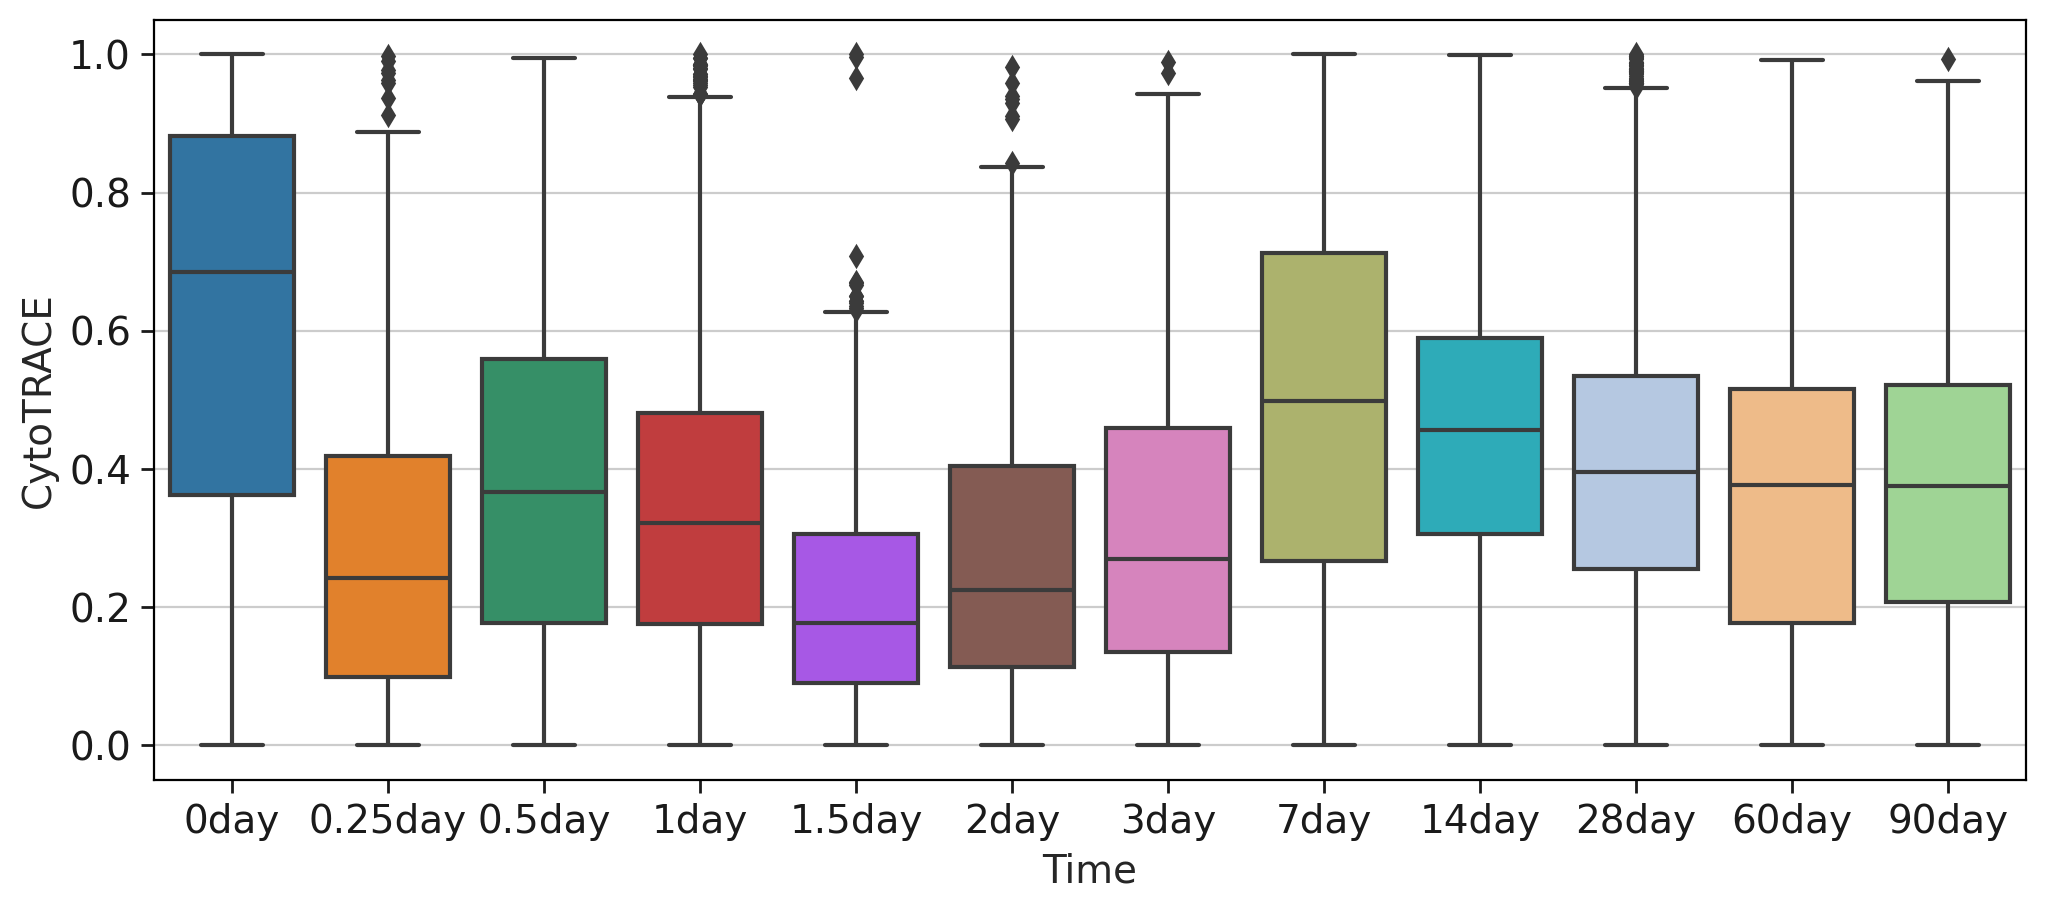

In [6]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x='Time',y='CytoTRACE', data=noci_mdata[noci_mdata.obs.Conditions != 'Sham'].obs, ax=ax)
plt.show()

In [34]:
noci_mdata.write('./Results_h5ad/05_noci_mdata_subcluster_CytoTRACE.h5mu')

In [2]:
noci_mdata = mu.read('./Results_h5ad/05_noci_mdata_subcluster_CytoTRACE.h5mu')

In [3]:
adata = noci_mdata['rna'].copy()

In [4]:
adata.obsm['X_umap'] = noci_mdata.obsm['X_umap']
adata.obs['PainState'] = noci_mdata.obs['PainState'].astype('category')
adata.obs['subtype'] = noci_mdata.obs['subtype'].astype('category')

In [5]:
adata.X = adata.layers['NB_counts'].copy()

import scFates as scf
scf.pp.batch_correct(adata, depth_scale=1e4, batch_key='Source', layer='NB_counts')

Performing pagoda2 batch correction
    depth scaling
    finished (0:00:19) --> updated 
    .layer['NB_counts'], batch corrected matrix.


In [6]:
noci_mdata['rna'].layers['NB_corrected'] = adata.X.copy()

In [7]:
# noci_mdata.write('./Results_h5ad/05_noci_mdata_subcluster_CytoTRACE.h5mu')

# Compute RNA velocity with CytoTrace Kernel

In [3]:
noci_mdata = mu.read('./Results_h5ad/05_noci_mdata_subcluster_CytoTRACE.h5mu')

In [4]:
adata = noci_mdata['rna'].copy()
adata.obsm['X_umap'] = noci_mdata.obsm['X_umap']
adata.obs['PainState'] = noci_mdata.obs['PainState'].astype('category')
adata.obs['subtype'] = noci_mdata.obs['subtype'].astype('category')

In [5]:
del adata.layers['NB_correct']
del adata.layers['corrected']

/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


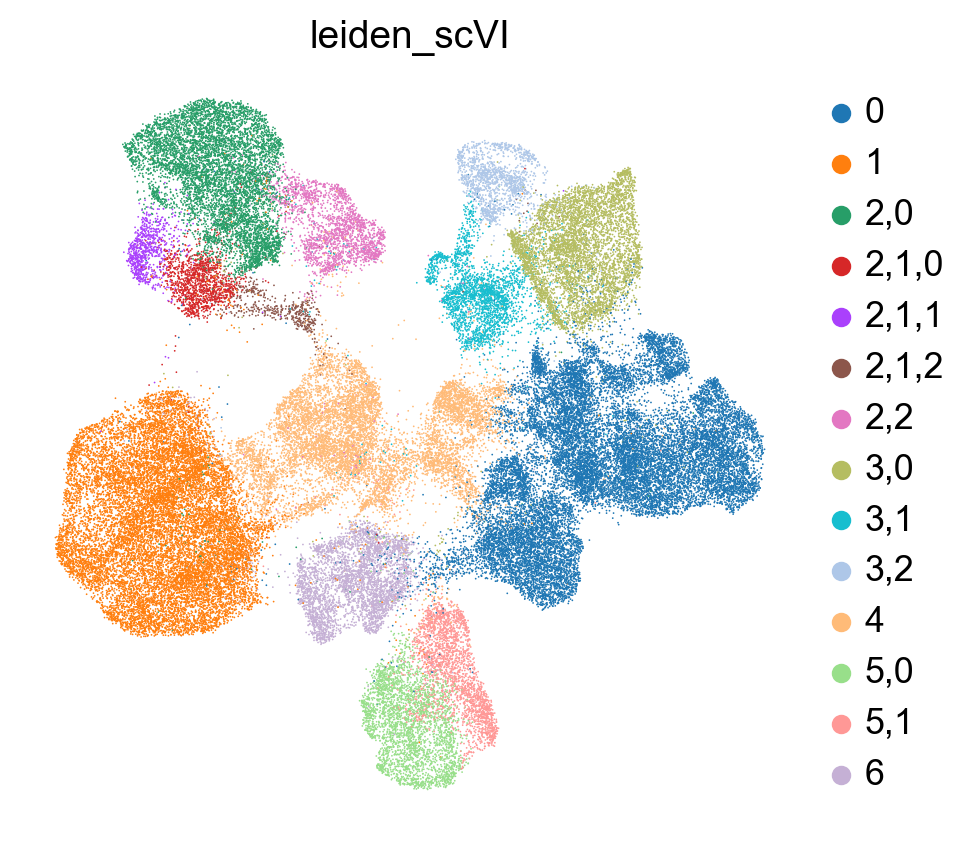

In [6]:
sc.pp.neighbors(adata, use_rep='X_scVI', n_neighbors=50, metric='correlation')
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_scVI')
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_scVI',restrict_to=('leiden_scVI',['2']))
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_scVI',restrict_to=('leiden_scVI',['2,1']))
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_scVI',restrict_to=('leiden_scVI',['3']))
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_scVI',restrict_to=('leiden_scVI',['5']))
sc.pl.umap(adata, color=['leiden_scVI'])

In [7]:
adata.obs['PainCon'] = adata.obs['leiden_scVI'].map(lambda x: 'Pain' if x in ['2,1,2','2,2','3,1','4','5,1'] else 'noPain')
adata.obs['PainCon']= adata.obs['PainCon'].astype('category').cat.reorder_categories(['noPain', 'Pain'])

/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


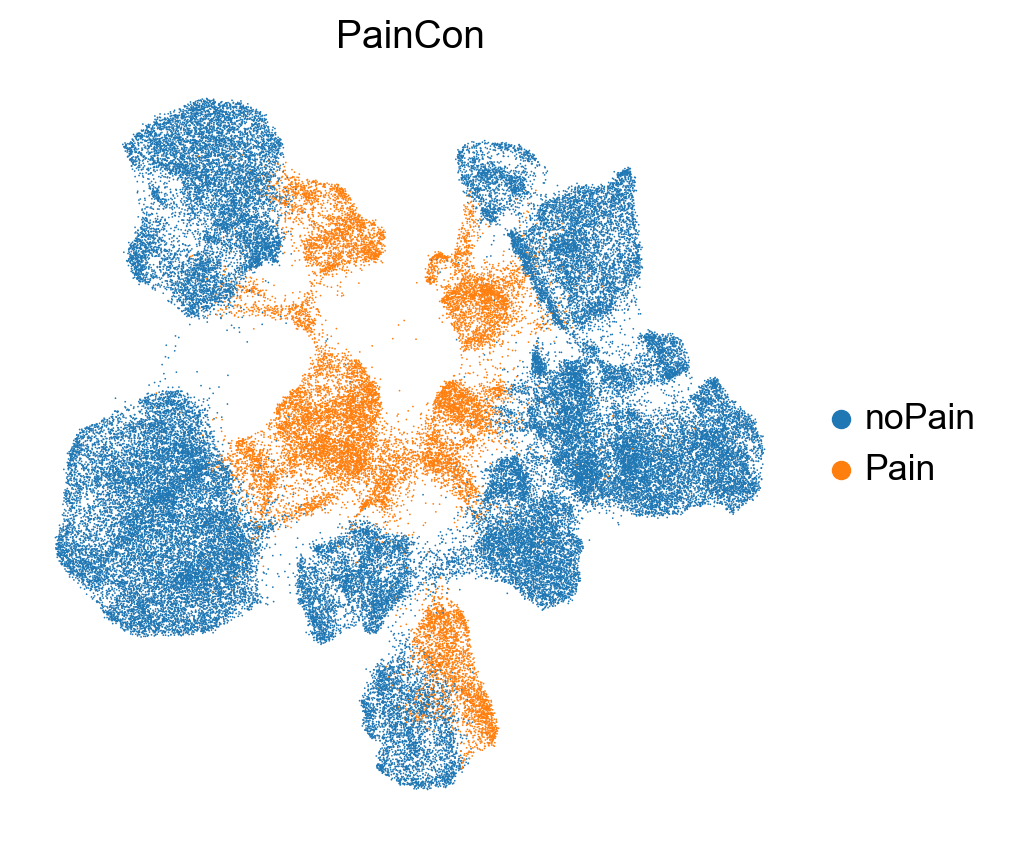

In [8]:
sc.pl.umap(adata, color=['PainCon'])

In [9]:
adata.obs['subtype_PainState'] = adata.obs['subtype'].astype(str) + '&' + adata.obs['PainCon'].astype(str)

In [10]:
del noci_mdata

In [11]:
adata.X = adata.layers['NB_counts'].copy()
sc.pp.filter_genes(adata, min_cells=adata.shape[0]*0.01)
adata.X = adata.layers['NB_corrected'].copy()

In [ ]:
import scanpy.external as sce
sc.pp.log1p(adata)
sce.pp.magic(adata)
adata.layers['magic'] = adata.X.copy()

In [12]:
%%R -o ct_score -o ct_pseudotime -o num_exp_genes -o name_gene_corr -o gene_corr
ct <- readRDS("./cyto_results.rds")
ct_score <- ct$CytoTRACE
ct_pseudotime <- 1-ct$CytoTRACE
num_exp_genes <- ct$Counts
name_gene_corr <- names(ct$gcsGenes)
gene_corr <- ct$gcsGenes

In [13]:
# Use pre-computed CytoTRACE results
gene_corr_dict = dict(zip(name_gene_corr, gene_corr))
adata.obs['ct_score'] = ct_score
adata.obs['ct_pseudotime'] = ct_pseudotime
adata.obs['ct_num_exp_genes'] = num_exp_genes
adata.var['ct_gene_corr'] = adata.var_names.map(gene_corr_dict)
top_pos_genes = adata.var['ct_gene_corr'].sort_values(ascending=False)[:200].index.to_list()
adata.var['ct_correlates'] = False
adata.var.loc[top_pos_genes, 'ct_correlates'] = True

In [15]:
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
print(f"This detected {adata.var['highly_variable'].sum()} highly variable genes. ")

This detected 4408 highly variable genes. 


In [16]:
adata.X = adata.layers['NB_corrected'].copy()
sc.pp.log1p(adata)
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X

import scvelo as scv
# scv.pp.moments(adata, n_pcs=30, n_neighbors=30, use_rep="X_scVI")
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing moments based on connectivities
    finished (0:01:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
from cellrank.kernels import CytoTRACEKernel

# ctk = CytoTRACEKernel(adata).compute_cytotrace(aggregation='mean')
ctk = CytoTRACEKernel(adata)

/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/cellrank/pl/_heatmap.py:10: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


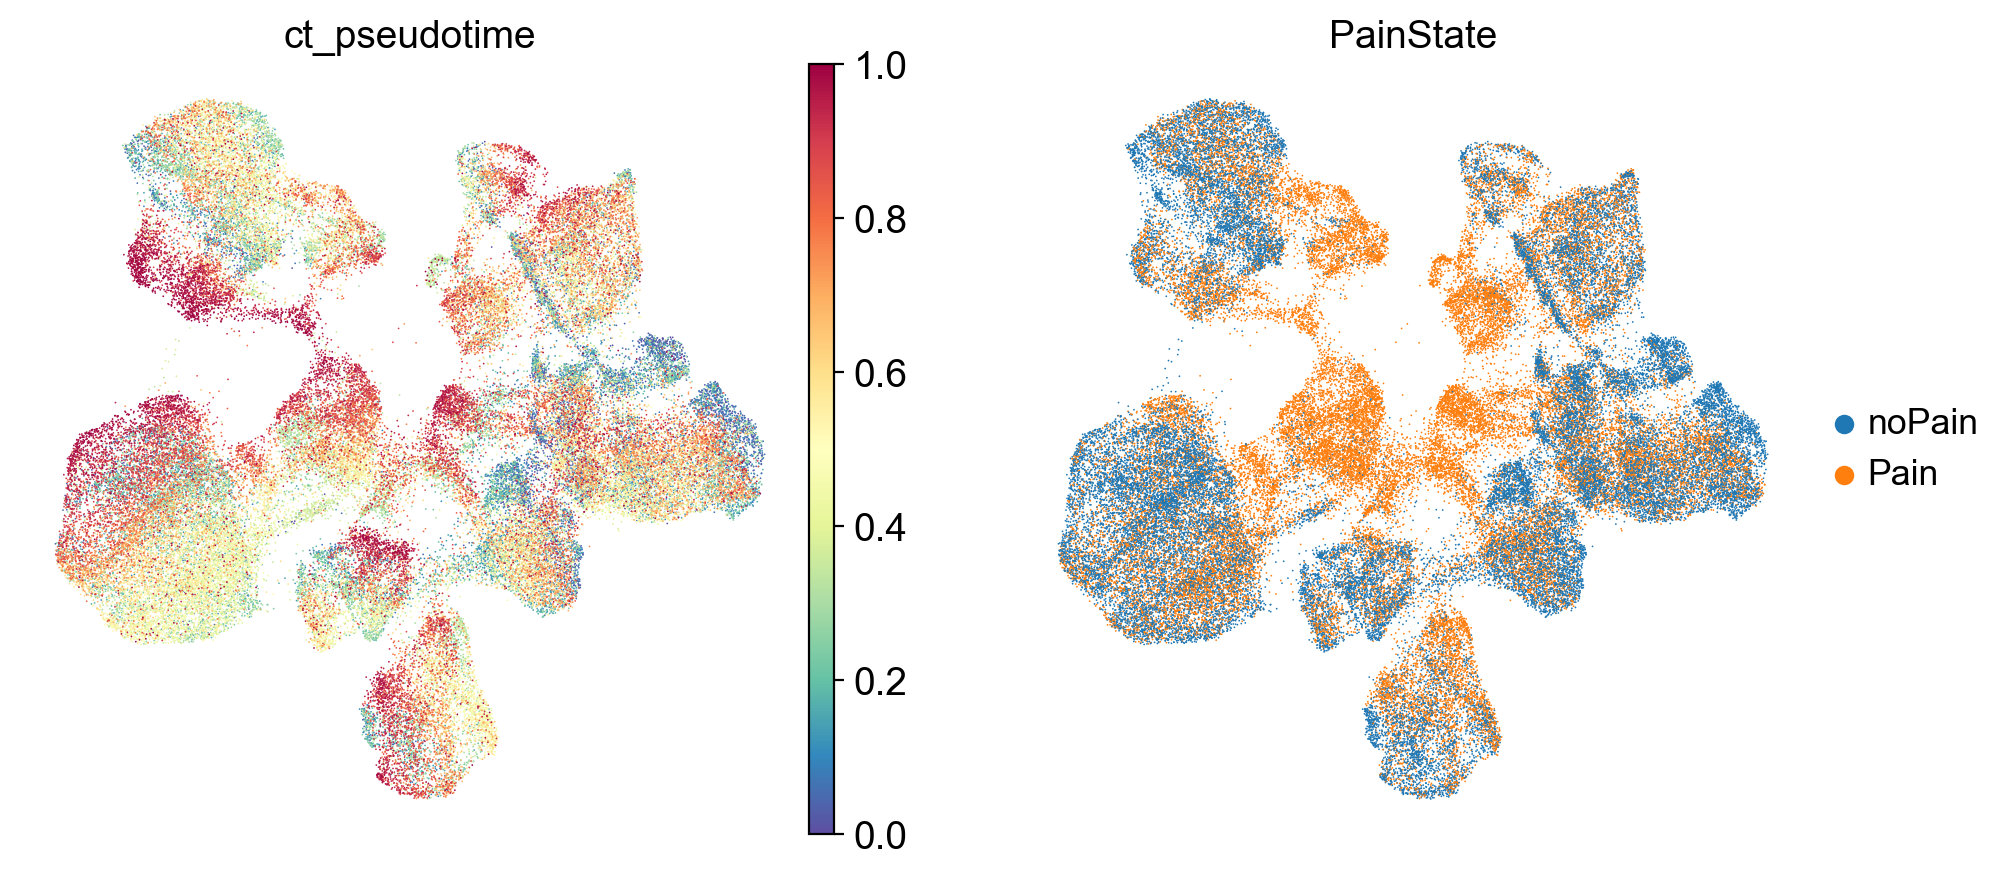

In [18]:
sc.pl.embedding(
    adata,
    color=["ct_pseudotime", "PainState"],
    basis="umap",
    color_map="Spectral_r",
)

In [15]:
adata.obs.Conditions = adata.obs.Conditions.cat.reorder_categories(['Naive', 'Sham', 'CFA', 'Paclitaxel', 'Crush', 'DRC','CCI', 'ScNT', 'SpNT'])

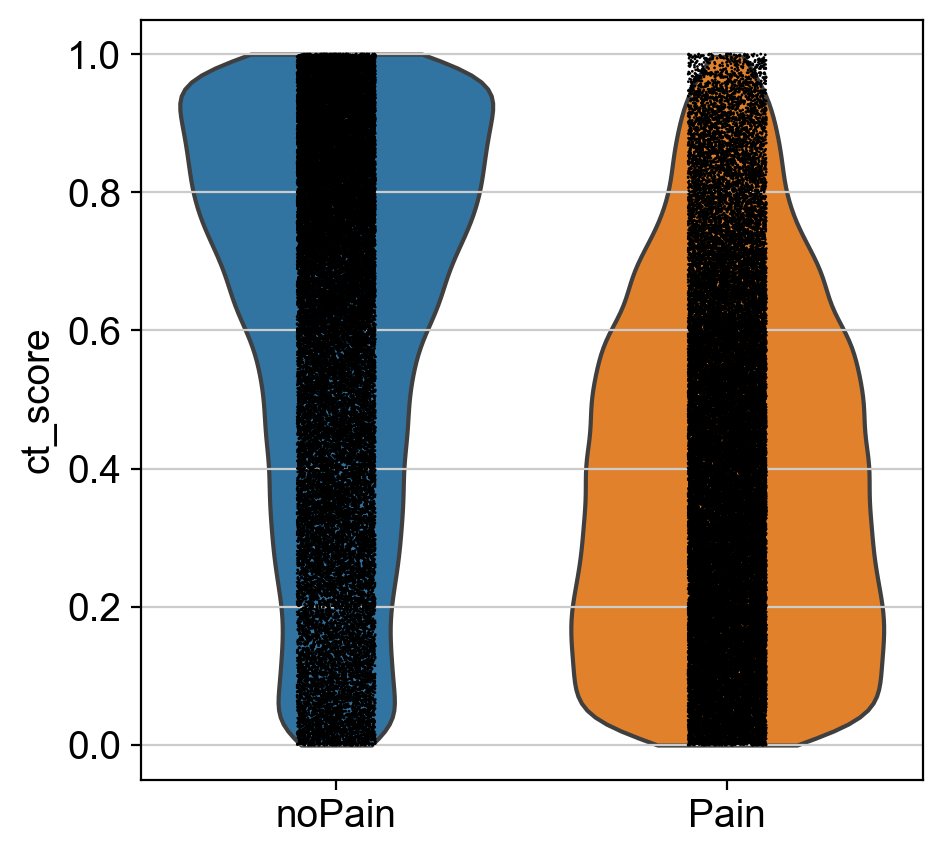

Ttest_indResult(statistic=106.60931942248288, pvalue=0.0001312163758037003)

In [14]:
from scipy import stats

sc.pl.violin(adata, keys=["ct_score"], groupby="PainState", rotation=0)
a = adata.obs.ct_score[adata.obs.PainState == 'noPain']
b = adata.obs.ct_score[adata.obs.PainState == 'Pain']
stats.ttest_ind(a, b, equal_var=False, alternative='greater', random_state=42, permutations=round(adata.shape[0]*.1))

Text(0, 0.5, 'CytoTrace score')

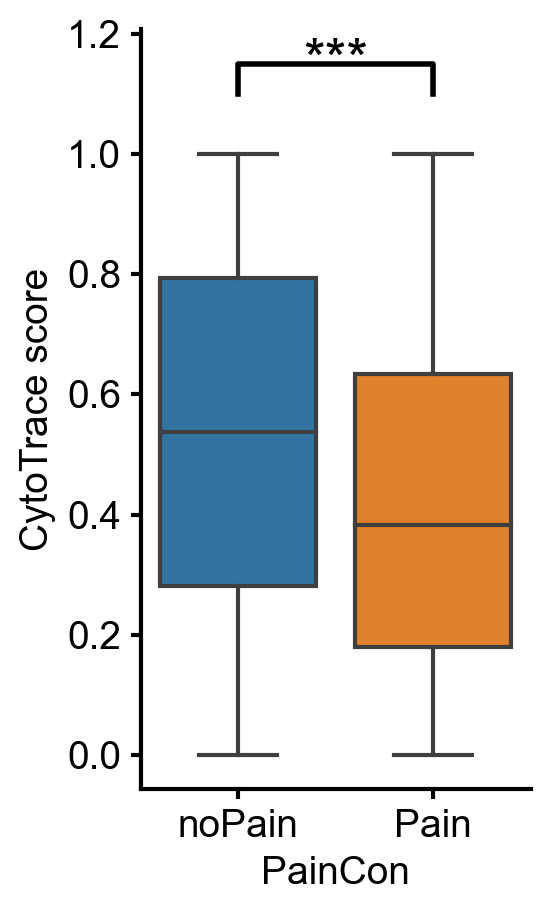

In [13]:
fig, ax = plt.subplots(figsize=(2.5,5))
# sc.pl.violin(adata, keys=["ct_score"], groupby="PainState", rotation=0, show=False, ax=ax, jitter=False, stripplot=False)
sns.boxplot(x='PainCon', y='ct_score', data=adata.obs, ax=ax)

max_val = max(adata.obs.ct_score)
plt.plot([0,0,1,1], [max_val+0.1, max_val+0.15, max_val+0.15, max_val+0.1], lw=2, c='k')
plt.text(0.5, max_val+0.15, '***', ha='center', va='center', fontsize=20)


ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

ax.tick_params(width=1.5)
# ax.set_ylabel('CytoTrace score', fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_ylabel('CytoTrace score')

In [22]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5, n_jobs=-1)

  0%|          | 0/76203 [00:00<?, ?cell/s]

CytoTRACEKernel[n=76203, dnorm=False, scheme='soft', b=10.0, nu=0.5]

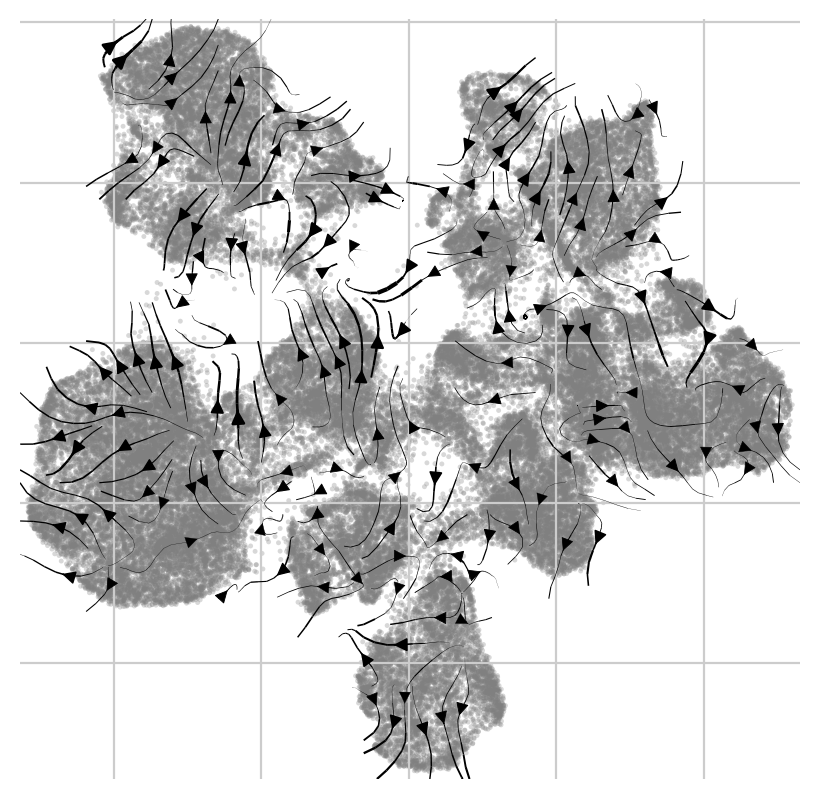

In [23]:
ctk.plot_projection(basis="umap", key_added='CT')

/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/pax/miniconda3/envs/cellrank2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'PainState'}, xlabel='UMAP1', ylabel='UMAP2'>

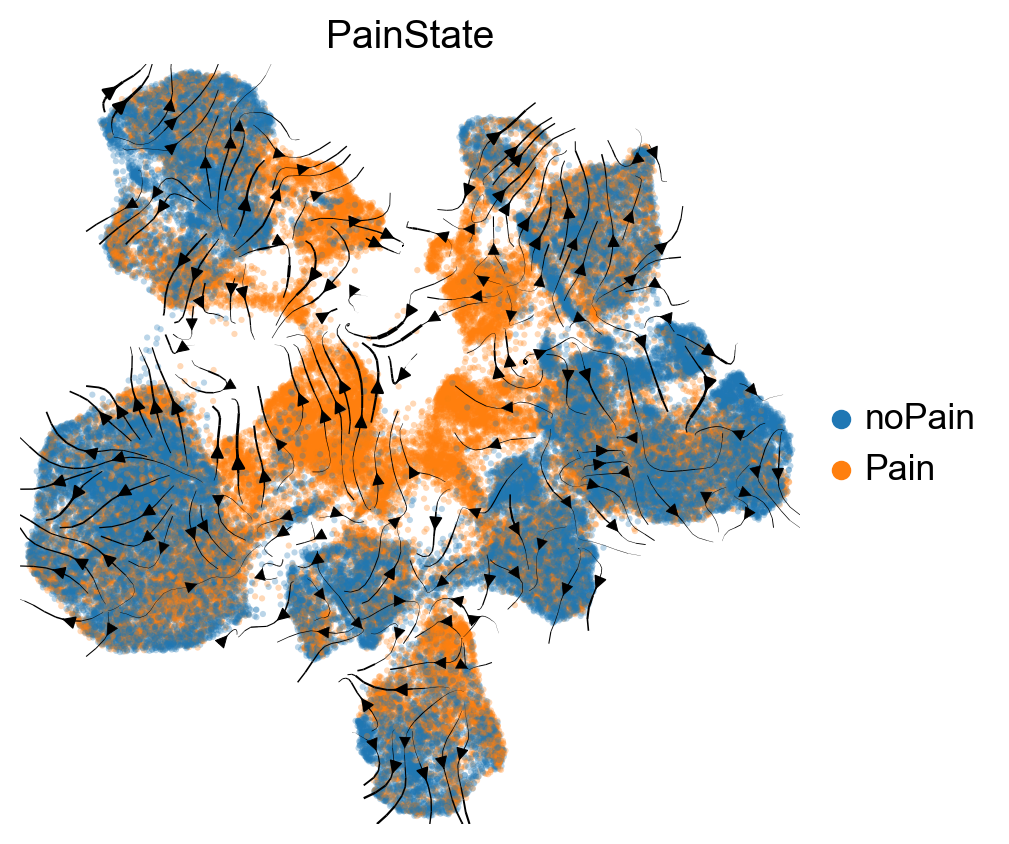

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
scv.pl.velocity_embedding_stream(ctk.adata, V=adata.obsm['CT_umap'], show=False, ax=ax, color='white')
ax.grid(False)
sc.pl.umap(adata, color='PainState', ax=ax, show=False, size=2, alpha=0.3, s=20)

In [25]:
adata.obs['Time_'] = adata.obs.Time.str.split('day').str[0].astype(float).astype('category')
adata.obs['Time_num'] = adata.obs.Time.str.split('day').str[0].astype(float)

# Apply estimators for each subtype

In [17]:
adata.obs['subtype_PainState'] = adata.obs['subtype'].astype(str) + '&' + adata.obs['PainCon'].astype(str)

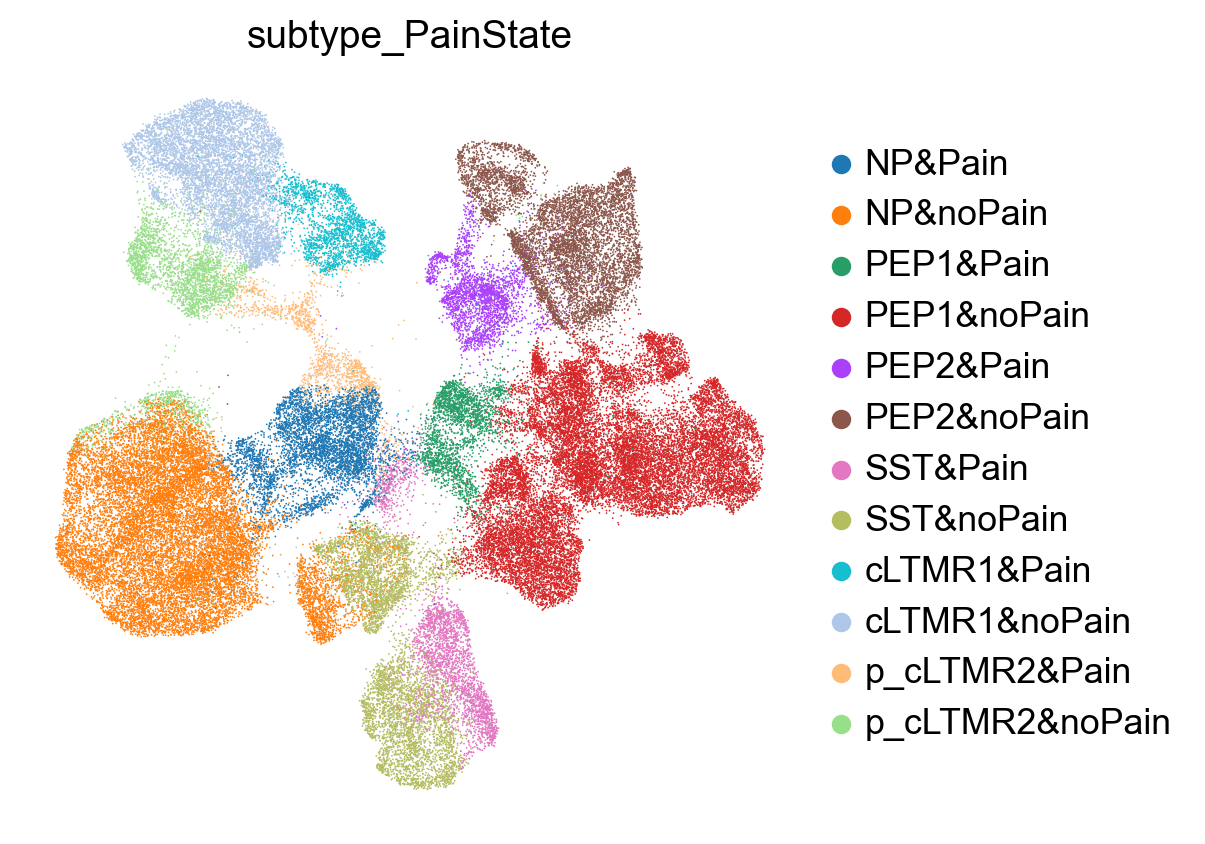

In [18]:
sc.pl.umap(adata, color='subtype_PainState')

In [59]:
adata.write_h5ad('./Results_h5ad/05_noci_adata_cellrank2_CytoTRACE_prep.h5ad', compression='gzip')

In [ ]:
adata = sc.read_h5ad('./Results_h5ad/05_noci_adata_cellrank2_CytoTRACE_prep.h5ad')